In [51]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [28]:
data = pd.read_csv('data/training_set_VU_DM.csv')

In [29]:
data['target'] = 4* data['booking_bool'] + data['click_bool']
data['target'].loc[data['target'].isna()] = int(0)
data['target'] = data['target'].astype(int)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_51237/251966437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].loc[data['target'].isna()] = int(0)


<Axes: >

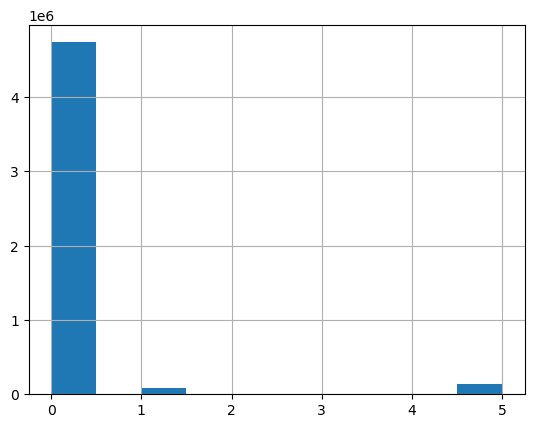

In [30]:
data['target'].hist()

In [31]:
data['target'].value_counts()

0    4736468
5     138390
1      83489
Name: target, dtype: int64

In [32]:
data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,target
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,0


In [33]:
# get search ids with any booking
ids = data['srch_id'].loc[data['booking_bool'] == 1].unique()

In [34]:
# use only the searches that resulted in a booking
data = data.loc[data['srch_id'].isin(ids)]

In [35]:
# undersample non bookings
X_under, y_under = resample(data.drop(['srch_id','date_time','click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[data['target'] == 0], data['target'].loc[data['target'] == 0]
                                      , n_samples=1 * sum(data['target'] != 0), replace=False)

In [36]:
X_bal = pd.concat([X_under, data.drop(['srch_id','date_time','click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[data['target'] != 0]])

y_bal = y_under
y_bal = y_bal.append(data['target'].loc[data['target'] != 0])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_51237/3689101729.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_bal = y_bal.append(data['target'].loc[data['target'] != 0])


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)

In [76]:
categoricals = ['prop_country_id', 'prop_starrating','prop_brand_bool', 'promotion_flag',
                'srch_saturday_night_bool', 'random_bool']

#baseline = HistGradientBoostingRegressor(max_leaf_nodes=None, max_depth=4, categorical_features= categoricals)

# much better than just replacing with 0
X_train = X_train.fillna(-9999)
baseline = GradientBoostingRegressor(max_leaf_nodes=None, max_depth=4, max_features=int(np.sqrt(X_train.shape[1])))
baseline.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=4, max_features=6)

In [71]:
pred = baseline.predict(data.drop(['srch_id','date_time','click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [73]:
mean_squared_error(data['target'], pred)

4.1028523366618606

In [77]:
pred_test = baseline.predict(X_test.fillna(-9999))
mean_squared_error(y_test, pred_test)

5.553784736070929

In [41]:
pred

array([2.18552055, 1.75564194, 1.39683155, ..., 1.8536125 , 2.26817998,
       1.58517905])

(array([114316.,      0.,  10602.,      0.,      0.,      0.,      0.,
             0.,      0., 103782.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

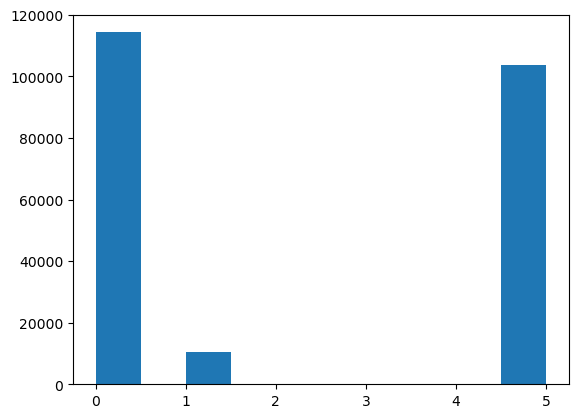

In [42]:
plt.hist(y_train)

## Predict the test dataset and bring it into requested format

In [43]:
test_data = pd.read_csv('data/test_set_VU_DM.csv')

In [44]:
test_data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,5543,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,14142,2,3.5,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,22393,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,24194,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
X = test_data.drop(['srch_id','date_time'], axis=1)

In [46]:
X[X['comp4_rate'] == 'NUL']  = np.nan

In [47]:
test_data['prediction'] = baseline.predict(X)

In [48]:
# sort values for final format
test_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [49]:
filename = 'data/predictions/prediction.csv'+str(datetime.now())
test_data[['srch_id', 'prop_id']].to_csv(filename, index=False)